## Convolutional Auto-Encoders

This notebook will be relatively brief, as we will implement a different technique for autoencoders.  All of our data flow, training, etc will be identical, except that the model will be different.

In [1]:
# This is the same from noteboook 2:
# Load the data generator and tensorflow:

import tensorflow as tf
import numpy
tf.enable_eager_execution()
from src.utils import data_generator

In [2]:
# Note that we are loading different models here:
from src.models import convolutional_AE

# Core training parameters:
N_TRAINING_ITERATION = 5000
BATCH_SIZE = 64
NUM_DIGITS = 1

In [3]:
# Let's set up our models:

encoder = convolutional_AE.Encoder()
decoder = convolutional_AE.Decoder()



In [4]:
data_gen = data_generator.mnist_generator()

# Load some data:
batch_images, batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
# Reshape the data:
batch_images = batch_images.reshape([BATCH_SIZE, 28, 28*NUM_DIGITS, 1])

intermediate_state = encoder(batch_images)
decoded_images = decoder(intermediate_state)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print("Here is the encoder model:")
encoder.summary()
print("Here is the intermediate representation shape:")
print(intermediate_state.shape)
print("Here is the decoder model: ")
decoder.summary()
print("Here is the decoded images shape:")
print(decoded_images.shape)

Here is the encoder model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  624       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  10416     
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  76864     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  5770      
Total params: 93,674
Trainable params: 93,674
Non-trainable params: 0
_________________________________________________________________
Here is the intermediate representation shape:
(64, 10)
Here is the decoder model: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTra

This model has many fewer parameters than the dense neural networks.  Let's see how the performance does!

In [6]:
# For an optimizer, we will use Adam Optimizer:

optimizer = tf.train.AdamOptimizer()



In [7]:
data_gen = data_generator.mnist_generator()

loss_history = []
val_loss_history = []
val_steps = []

for i in range(N_TRAINING_ITERATION):

    # Load some data:
    batch_images, batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
    # Reshape the data:
    batch_images = batch_images.reshape(
        [BATCH_SIZE, 28, 28*NUM_DIGITS, 1])

    with tf.GradientTape() as tape:
        intermediate_state = encoder(batch_images)
        decoded_images = decoder(intermediate_state)
        loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)

    if i % 50 == 0:
        test_images, test_labels = data_gen.next_test_batch(BATCH_SIZE, NUM_DIGITS)
        test_images = test_images.reshape(
            [BATCH_SIZE, 28, 28*NUM_DIGITS, 1])
        val_intermediate_state = encoder(test_images)
        val_decoded_images = decoder(intermediate_state)
        val_loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)
        val_loss_history.append(val_loss_value.numpy())
        val_steps.append(i)
        
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables


    loss_history.append(loss_value.numpy())

    # Apply the update to the model:
    grads = tape.gradient(loss_value, trainable_vars)
    optimizer.apply_gradients(zip(grads, trainable_vars),
                             global_step=tf.train.get_or_create_global_step())

    if i % 50 == 0:
        print("Step {}, loss {}".format(i, loss_history[-1]))

Instructions for updating:
Use tf.cast instead.
Step 0, loss 0.11130475997924805
Step 50, loss 0.06297559291124344
Step 100, loss 0.04621368646621704
Step 150, loss 0.03594160079956055
Step 200, loss 0.028748583048582077
Step 250, loss 0.02332240901887417
Step 300, loss 0.024166831746697426
Step 350, loss 0.02321595326066017
Step 400, loss 0.023148609325289726
Step 450, loss 0.02283482626080513
Step 500, loss 0.02069823630154133
Step 550, loss 0.02069101482629776
Step 600, loss 0.021091587841510773
Step 650, loss 0.020095493644475937
Step 700, loss 0.020875969901680946
Step 750, loss 0.02039342187345028
Step 800, loss 0.01912715472280979
Step 850, loss 0.0181583222001791
Step 900, loss 0.017423108220100403
Step 950, loss 0.020500952377915382
Step 1000, loss 0.017533177509903908
Step 1050, loss 0.0189998559653759
Step 1100, loss 0.017820529639720917
Step 1150, loss 0.01677093841135502
Step 1200, loss 0.017033545300364494
Step 1250, loss 0.017145659774541855
Step 1300, loss 0.01701193302

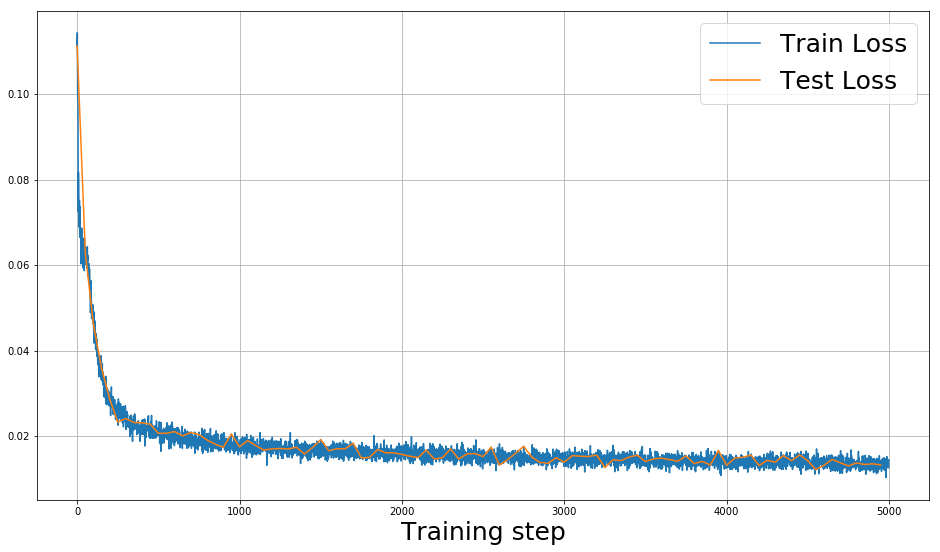

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(16,9))
plt.plot(range(len(loss_history)), loss_history, label="Train Loss")
plt.plot(val_steps, val_loss_history, label="Test Loss")
plt.grid(True)
plt.legend(fontsize=25)
plt.xlabel("Training step", fontsize=25)
plt.show()

As in the fully connected network, the loss appears to have converged pretty well.  Let's look at some images on the other side of the encoder:

In [9]:
def run_inference(_encoder, _decoder, input_images):

    N_INFERENCE_IMAGES = input_images.shape[0]
    input_images = input_images.reshape(N_INFERENCE_IMAGES, 
                                        28, 
                                        28*NUM_DIGITS,
                                       1)
    intermediate_rep = _encoder(input_images)
    decoded_images = _decoder(intermediate_rep)
    decoded_images = decoded_images.numpy().reshape(
        N_INFERENCE_IMAGES*28, NUM_DIGITS*28)
    
    return intermediate_rep, decoded_images

In [10]:
N_INFERENCE_IMAGES = 2


original_images, labels = data_gen.next_train_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

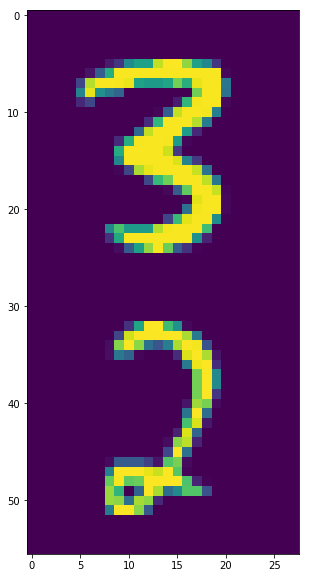

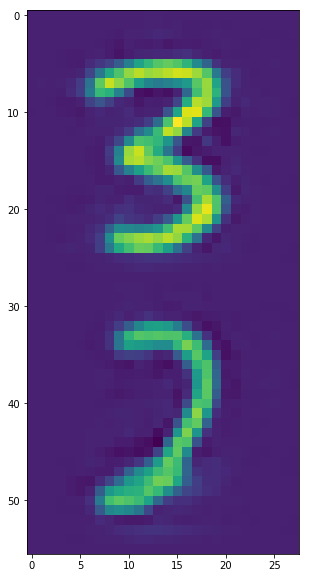

In [11]:
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images)
plt.show()

Again, the decoded images are recognizable and correspond to the input images, though they are not identical.

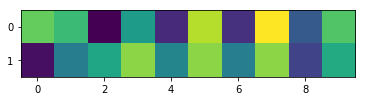

In [12]:
plt.imshow(intermediate_rep)
plt.show()

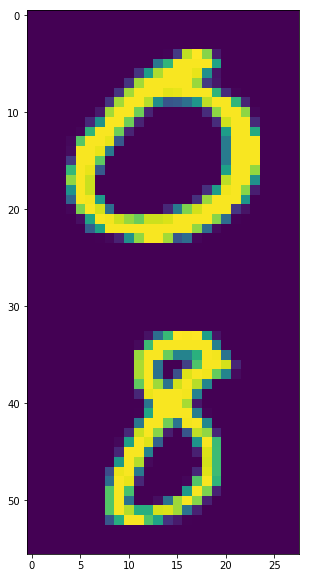

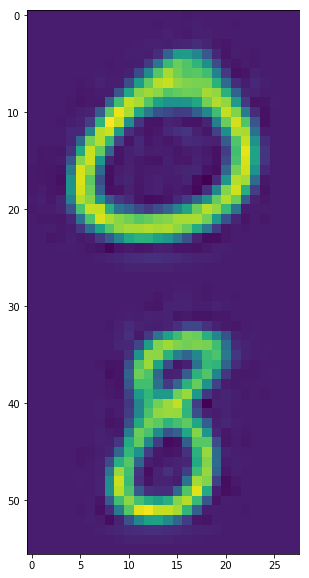

In [13]:
N_INFERENCE_IMAGES = 2


original_images, labels = data_gen.next_test_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images)
plt.show()

Once again, the network is performing well on the validation test set.  Save the networks since they will be loaded and used in the next notebook:

In [14]:
# Save the trained models again:
encoder.save_weights("saved_models/user/conv_encoder.h5")
decoder.save_weights("saved_models/user/conv_decoder.h5")